In [661]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
sia = SentimentIntensityAnalyzer()
STOPWORDS = set(stopwords.words('english'))
from autocorrect import Speller
spell = Speller()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\v-bmangheni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [662]:
#Reading the csv data and saving it into a data frame
data = pd.read_csv("./data/data.csv")
data.head(2)

C:\Users\v-bmangheni\AppData\Local\Temp\ipykernel_21808\2169224654.py:2: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./data/data.csv")


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman


In [663]:
#Since we are only interested in sentiment analysis we will only use reviews.text and reviews.rating
data = data[["reviews.text", "reviews.rating"]]
data.head()

,reviews.text,reviews.rating
0,This product so far has not disappointed. My c...,5.0
1,great for beginner or experienced person. Boug...,5.0
2,Inexpensive tablet for him to use and learn on...,5.0
3,I've had my Fire HD 8 two weeks now and I love...,4.0
4,I bought this for my grand daughter when she c...,5.0


In [664]:
#Checking null values: 34 in total
data.isnull().sum()

reviews.text       1
reviews.rating    33
dtype: int64

In [665]:
#Shape of the data before dropping null values
data.shape

(34660, 2)

In [666]:
#Drop the null values and then re-assign data to cleaned version of data
data = data.dropna()

In [667]:
# Shape after cleaning the data, all the 34 rows with null values have been removed
data.shape

(34626, 2)

In [668]:
# Checking to confirm the null values have been removed
data.isna().sum()

reviews.text      0
reviews.rating    0
dtype: int64

In [669]:
# Checking the data types for the text and ratings columns, which is String and float.
data.dtypes

reviews.text       object
reviews.rating    float64
dtype: object

In [670]:
def map_sentiments (data_param):
    sentiment_score = {1: 0,
                   2: 0,
                   3: 1,
                   4: 2,
                   5: 2}
    sentiment = {
                0: "NEGATIVE",
                1: "NEUTRAL",
                2: "POSITIVE"
}
    
    data_param["sentiment_score"] = data["reviews.rating"].map(sentiment_score)
    data_param["sentiment"] = data["sentiment_score"].map(sentiment)
    return data_param


In [671]:
# We then create a new column to hold the length of text reviews submitted, we can use this to co-relate the length of the feedback to the ratings i.e Happy customers would submit longer reviews
data["length"] = data["reviews.text"].apply(len)
# We then map ratings to sentiment scores and sentiments
data = map_sentiments(data)

In [672]:
#Check the shape of the data after adding the two columns
data.head(10)

,reviews.text,reviews.rating,length,sentiment_score,sentiment
0,This product so far has not disappointed. My c...,5.0,143,2,POSITIVE
1,great for beginner or experienced person. Boug...,5.0,75,2,POSITIVE
2,Inexpensive tablet for him to use and learn on...,5.0,131,2,POSITIVE
3,I've had my Fire HD 8 two weeks now and I love...,4.0,593,2,POSITIVE
4,I bought this for my grand daughter when she c...,5.0,613,2,POSITIVE
5,This amazon fire 8 inch tablet is the perfect ...,5.0,209,2,POSITIVE
6,"Great for e-reading on the go, nice and light ...",4.0,115,2,POSITIVE
7,"I gave this as a Christmas gift to my inlaws, ...",5.0,132,2,POSITIVE
8,Great as a device to read books. I like that i...,5.0,267,2,POSITIVE
9,I love ordering books and reading them with th...,5.0,55,2,POSITIVE


In [673]:
# Analyzing the rating column
data["sentiment_score"].value_counts()

sentiment_score
2    32315
1     1499
0      812
Name: count, dtype: int64

In [674]:
#To solve the huge imbalance in the number of feedback with higher ratings and lower ratings. This make sure the model will get a balanced proportion of data for different sentiments
# data5 = data[data['reviews.rating'] == 5].sample(700, random_state=43)
# data4 = data[data['reviews.rating'] == 4].sample(200, random_state=43)
# data3 = data[data['reviews.rating'] == 3]
# data2 = data[data['reviews.rating'] == 2]
# data1 = data[data['reviews.rating'] == 1]

data1 = pd.read_csv("./data/data1.csv")
data1 = data1[["reviews.text", "reviews.rating"]]
# Use only lower ratings
data1 = map_sentiments(data1)
data1 = data1[data1["sentiment_score"] <= 1]


data2 = pd.read_csv("./data/data2.csv")
data2 = data2[["reviews.text", "reviews.rating"]]
# Use only lower ratings
data2 = map_sentiments(data2)
data2 = data2[data2["sentiment_score"] <= 1]

data = pd.concat([data1,data2, data.sample(4000, random_state=43)])
data["sentiment_score"].value_counts()
data

,reviews.text,reviews.rating,sentiment_score,sentiment,length
117,Seem to work fone for a fraction of the price!,5.0,0.0,NEGATIVE,NaN
126,Works just as well as any other battery brand ...,5.0,0.0,NEGATIVE,NaN
169,I find these packs of batteries are less expen...,5.0,0.0,NEGATIVE,NaN
222,I have truly been converted form any other bat...,5.0,1.0,NEUTRAL,NaN
226,"This batteries were dirt cheap, way cheaper th...",5.0,1.0,NEUTRAL,NaN
...,...,...,...,...,...
29035,I understood it did not have the wake command....,4.0,2.0,POSITIVE,289.0
26590,Initially I bought the Amazon echo to take it ...,5.0,2.0,POSITIVE,444.0
13354,I purchased this for my cousin as a Christmas ...,5.0,2.0,POSITIVE,128.0
5056,I love this kindle! My old one lasted about tw...,5.0,2.0,POSITIVE,150.0


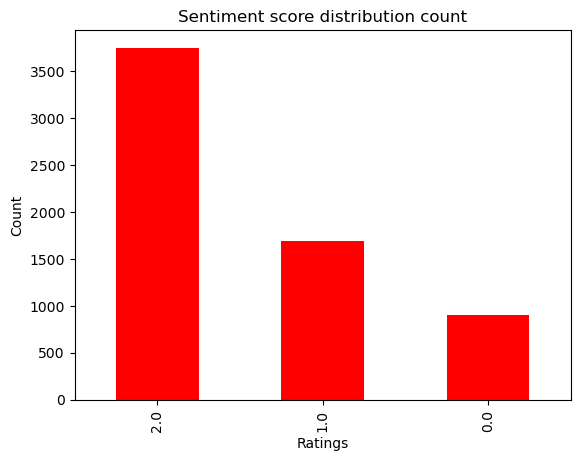

In [675]:
#Bar plot to visualize the total counts of each rating

data['sentiment_score'].value_counts().plot.bar(color = 'red')
plt.title('Sentiment score distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [676]:
data["length"].describe()

count    4000.000000
mean      155.066250
std       158.156597
min         5.000000
25%        69.000000
50%       103.000000
75%       178.000000
max      2234.000000
Name: length, dtype: float64

c:\Users\v-bmangheni\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of length of review ')]

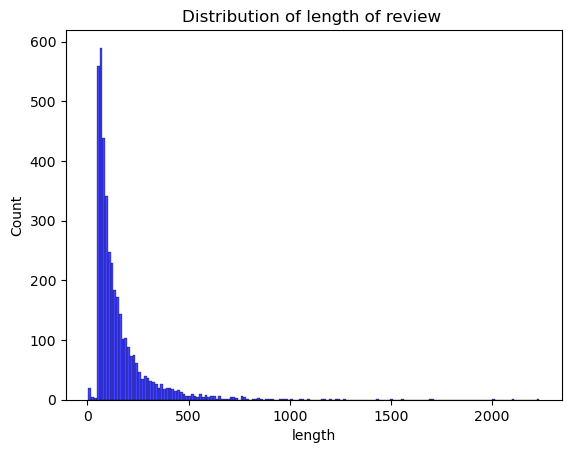

In [677]:
#The histogram shows that the majority of reviews are short, with a rapidly decreasing number of longer reviews.
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')


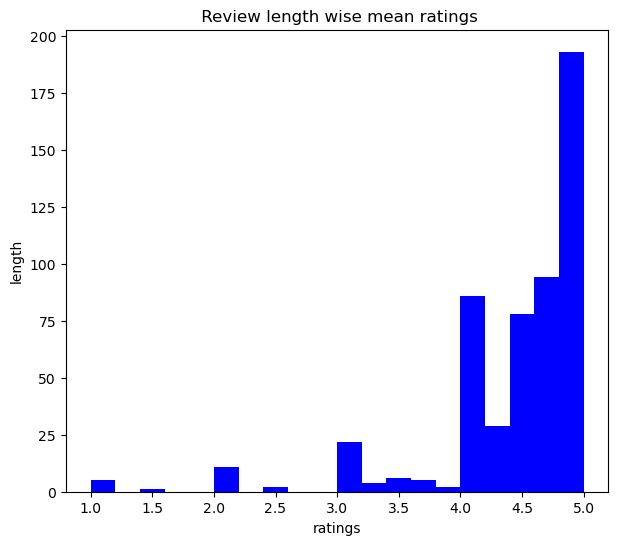

In [678]:
#Positive ratings have the longest average reviews
data.groupby('length')['reviews.rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [679]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data["reviews.text"])

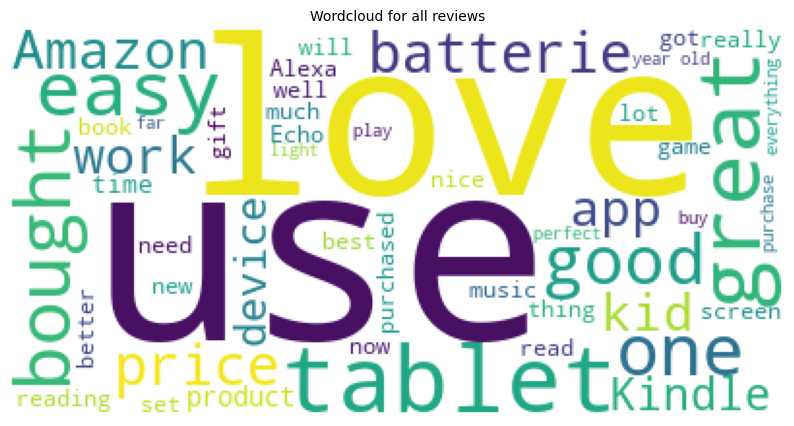

In [680]:
# Wordcloud for all words in data
# Combine all reviews
reviews = " ".join([review for review in data['reviews.text']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [681]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['sentiment_score'] == 0]['reviews.text']])
neg_reviews = neg_reviews.lower().split()

neutral_reviews = " ".join([review for review in data[data['sentiment_score'] == 1]['reviews.text']])
neutral_reviews = neutral_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['sentiment_score'] == 2]['reviews.text']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_neutral = [x for x in neg_reviews if x not in neutral_reviews]
unique_neutral = " ".join(unique_neutral)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

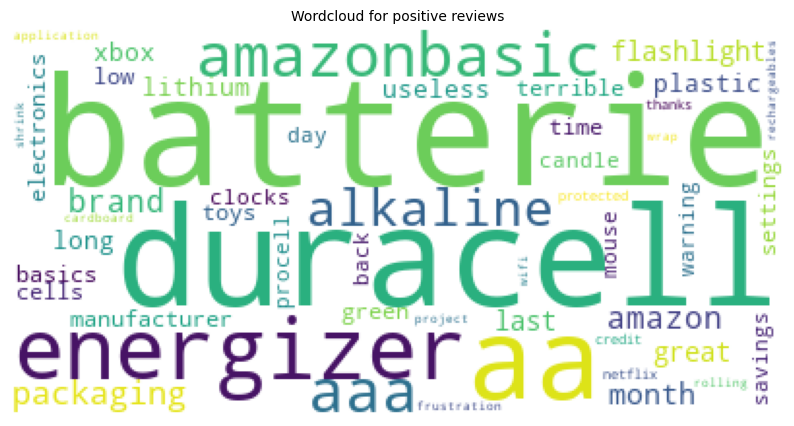

In [682]:
#Negative words
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

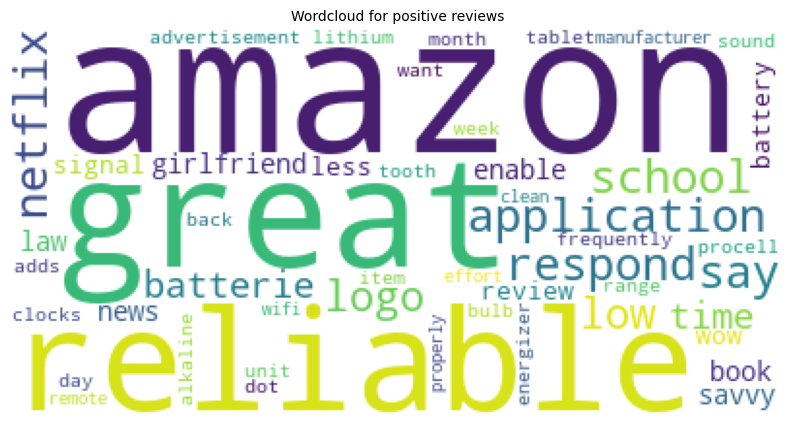

In [683]:
#Neutral words
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_neutral))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

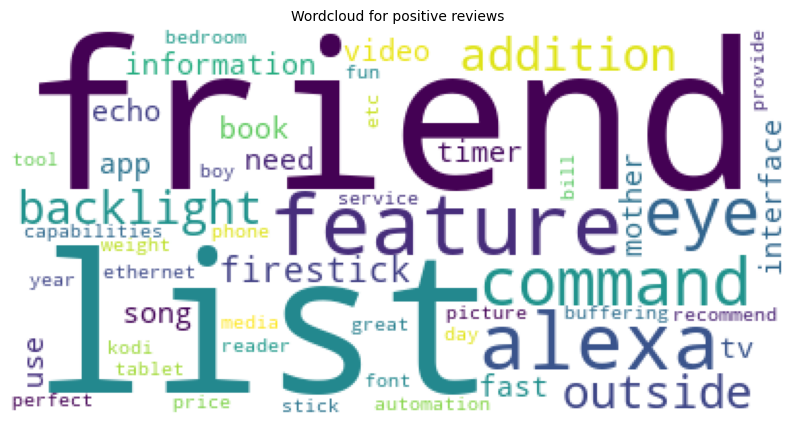

In [684]:
#Positive words
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

In [685]:
corpus = []
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['reviews.text'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [686]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['sentiment_score'].values

In [687]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [688]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (6340, 2500)
y shape: (6340,)


In [689]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (5072, 2500)
y train: (5072,)
X test: (1268, 2500)
y test: (1268,)


In [690]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 25
X test max value: 8


In [691]:
scaler = MinMaxScaler()


X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [692]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [699]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

LogisticRegression()

In [694]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.7766167192429022
Testing Accuracy : 0.610410094637224


In [695]:
y_preds = model_xgb.predict(X_test)


In [696]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 11  81 103]
 [ 17 105 173]
 [ 19  64 695]]


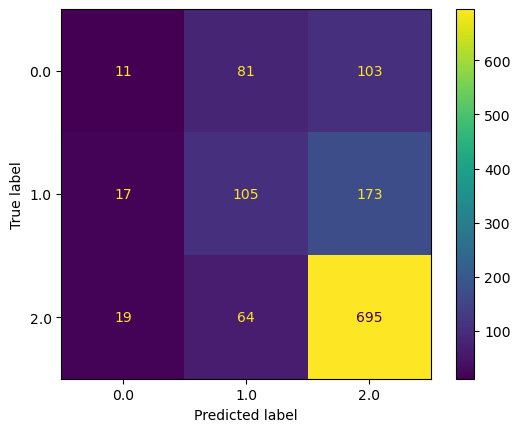

In [697]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [698]:
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))